# Decision Trees

Decision trees can be applied to both **regression** and **classification** problems.

### Entropy

Entropy of the observations $x_i$ is

$$
\begin{aligned}
\text{entropy} &= \sum -p(x_i) \; log_2(p(x_i)) \\
\text{cross-entropy} &= - p \; log_2(p) - (1 - p) \; log_2(1 - p)
\end{aligned}
$$

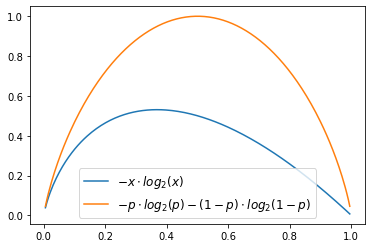

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 200)[1:-1]
entropy = lambda x: -x * np.log2(x)
cross_entropy = lambda x: - x * np.log2(x) - (1 - x) * np.log2(1 - x)
plt.plot(x, entropy(x), label=r'$-x \cdot log_2(x)$')
plt.plot(x, cross_entropy(x), label=r'$- p \cdot log_2(p) - (1 - p) \cdot log_2(1 - p)$')
plt.legend(fontsize='large');

Given a bucket of $m$ blue and $n$ red balls, the entropy calculates as

$$
\text{entropy} = - \frac{m}{m + n} log_2(\frac{m}{m + n}) - \frac{n}{m + n} log_2(\frac{n}{m + n})
$$

In [2]:
def entropy(n):
    p = n / np.sum(n)
    return np.sum(-p * np.log2(p))

In [3]:
entropy(np.array([4, 10]))

0.863120568566631

In [4]:
entropy(np.array([8, 3, 2]))

1.3346791410515946

## Building a Classifiction Decision Tree

A **decision tree** contains a **root node**, **branch nodes** and **leave nodes**. Leaves can be **impure** (having no clear result) or **pure**. There are several ways to quantify the **impurity** of leaves: **Gini Impurity**, **Entropy** or **Information Gain**.

The aim is to split the feature space into $J$ boxes. For that, we take a **top-down**, **greedy** approach that is known as **recursive binary splitting**. 

The approach is **top-down** because it begins at the **top of the tree** (at which point all observations belong to a single region) and then successively splits the predictor space; each split is indicated via two new branches further down on the tree. 

It is **greedy** because at each step of the tree-building process, the best split is made at that particular step, rather than looking ahead and picking a split that will lead to a better tree in some future step.

### Gini Index

Let $0 \leq \hat{p}_{mk} \leq 1$ be the portion of training observations in the $m$th region that are from the $k$th class.

The **Gini index**

$$
G_K = \sum_{k=1}^K \hat{p}_{mk} (1 - \hat{p}_{mk})
$$

is a measure of total variance across the $K$ classes. It is not hard to see that the Gini index takes on a small value if all of the $\hat{p}_{mk}$ are close to zero or one. For this reason the Gini index is referred to as a measure of node purity: a small value indicates that a node contains predominantly observations from a single class.

#### Gini Index for Binary Class

The Gini index of a leave $L$ for $K=2$ classes is

$$
\begin{aligned}
G_L &= \sum_{k=1}^2 \hat{p}_{mk} (1 - \hat{p}_{mk}) \\
&= \hat{p}_1 (1 - \hat{p}_1) + \hat{p}_2 (1 - \hat{p}_2) \\
&= \hat{p}_1 - \hat{p}_1^{\,2} + \hat{p}_2 - \hat{p}_2^{\,2} \\
&= 1 - \hat{p}_1^{\,2} - \hat{p}_2^{\,2}
\end{aligned}
$$

As the leaves do not represent the same number of observations, we use the **total gini index** which is the weighted average of Gini indexes of the two leaves:

$$
G = \frac{n_1}{n_1 + n_2} G_1 + \frac{n_2}{n_1 + n_2} G_2
$$

For a feature with continuous data, we first sort the observations, then we calculate the average value between each observation and calculate the Gini index for each.

### Entropy

The **entropy** is

$$
D_K = - \sum_{k=1}^K \hat{p}_{mk} log_2\,(\hat{p}_{mk})
$$

The entropy will take a value near zero if the $\hat{p}_{mk}$'s are all near zero or near one. Therefore, like the Gini index, the entropy will take on a small value if the $m$th node is pure.

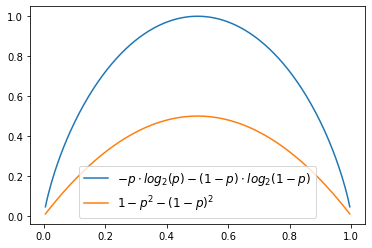

In [5]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 200)[1:-1]
entropy = lambda x: - x * np.log2(x) - (1 - x) * np.log2(1 - x)
gini = lambda x: 1 - x ** 2 - (1 - x) ** 2
plt.plot(x, entropy(x), label=r'$- p \cdot log_2(p) - (1 - p) \cdot log_2(1 - p)$')
plt.plot(x, gini(x), label=r'$1 - p^2 - (1 - p)^2$')
plt.legend(fontsize='large');

### Information Gain

The **average entropy** for the child groups will need to be a **weighted average**, based on the number of cases in each child group. That is, for $m$ items in the first child group and $n$ items in the second child group, the information gain is:

$$
\text{information-gain} = \text{entropy}(parent) - \frac{m}{m + n} \text{entropy}(child_1) - \frac{n}{m + n} \text{entropy}(child_2)
$$

### Example

In [24]:
import pandas as pd

df = pd.read_csv('data/ml-bugs.csv')
df.columns = df.columns.str.lower().str.replace(r' \(mm\)', '', regex=True)

df.head()

,species,color,length
0,Mobug,Brown,11.6
1,Mobug,Blue,16.3
2,Lobug,Blue,15.1
3,Lobug,Green,23.7
4,Lobug,Blue,18.4


In [26]:
def entropy(n):
    p = n / np.sum(n)
    return np.sum(-p * np.log2(p))

def information_gain(**kwargs):
    mobug = len(df[df.species=='Mobug'])
    lobug = len(df[df.species=='Lobug'])
    entropy_parent = entropy(np.array([mobug, lobug]))
    if 'color' in kwargs:
        color = kwargs['color']
        msg = f'color = {color}'
        m = len(df[df['color']==color])
        n = len(df[df['color']!=color])
        p1 = len(df[(df['color']==color) & (df.species=='Mobug')])
        q1 = len(df[(df['color']==color) & (df.species=='Lobug')])
        entropy_child_1 = entropy(np.array([p1, q1]))
        p2 = len(df[(df['color']!=color) & (df.species=='Mobug')])
        q2 = len(df[(df['color']!=color) & (df.species=='Lobug')])
        entropy_child_2 = entropy(np.array([p2, q2]))
    if 'length' in kwargs:
        length = kwargs['length']
        msg = f'length < {length}'
        m = len(df[df['length']<length])
        n = len(df[df['length']>=length])
        p1 = len(df[(df['length']<length) & (df.species=='Mobug')])
        q1 = len(df[(df['length']<length) & (df.species=='Lobug')])
        entropy_child_1 = entropy(np.array([p1, q1]))
        p2 = len(df[(df['length']>=length) & (df.species=='Mobug')])
        q2 = len(df[(df['length']>=length) & (df.species=='Lobug')])
        entropy_child_2 = entropy(np.array([p2, q2]))
    print(f'information_gain for {msg}: {entropy_parent - (m / (m + n) * entropy_child_1 + n / (m + n) * entropy_child_2)}')
    
information_gain(color='Brown')
information_gain(color='Green')
information_gain(color='Blue')
information_gain(length=17)
information_gain(length=20)

information_gain for color = Brown: 0.06157292259666325
information_gain for color = Green: 0.042776048498108565
information_gain for color = Blue: 0.000589596275060833
information_gain for length < 17: 0.11260735516748976
information_gain for length < 20: 0.10073322588651734


## Hyperparameters for Decision Trees

* **Maximum Depth**: the largest possible length between the root to a leaf. A tree of maximum length $k$ can have at most $2^k$ leaves. **Large depth** very often causes **overfitting**, since a tree that is too deep, can memorize the data. **Small depth** can result in a very simple model, which may cause **underfitting**.

* **Minimum number of samples to split**: A node must have at least `min_samples_split` samples in order to be large enough to split. Otherwise the splitting process stops. **Small minimum samples per split** may result in a complicated, highly branched tree, which can mean the model has memorized the data, or in other words, **overfit**. **Large minimum samples** may result in the tree not having enough flexibility to get built, and may result in **underfitting**.

* **Minimum number of samples per leaf**: When splitting a node, one could run into the problem of having `99` samples in one of them, and `1` on the other. This will not take us too far in our process, and would be a waste of resources and time. If a **threshold** on a feature results in a leaf that has fewer samples than `min_samples_leaf`, the algorithm will not allow that split.

## Advantages of Decision Tree

1. **Simple to understand**, interpret, visualize.
2. Requires **minimum pre-processing** of data — like removal of blanks, One-Hot encoding.
3. Able to handle both **numerical and categorical** data
4. **Performs well** even if its assumptions are somewhat violated by the true model from which the data were generated.

## Disadvantages of Decision Tree

1. **Over-fitting** — can create complex trees that don’t generalise well.
2. **Unstable to data variations**. Ensemble methods like random forest help in avoiding this problem.
3. Class imbalance **can create biased trees**.

## Decision Tree with SciKit-Learn

In [8]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv('data/ml-bugs.csv')
df = pd.concat([df, pd.get_dummies(df['Color'])], axis=1)
df.drop(['Color'],axis=1, inplace=True)
df.columns = df.columns.str.lower().str.replace(r' \(mm\)', '', regex=True)

X, y = df.iloc[:, -4:], df.iloc[:, [0]]

model = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2)
model.fit(X, y)

DecisionTreeClassifier()

In [9]:
model.classes_

array(['Lobug', 'Mobug'], dtype=object)

In [10]:
model.predict([[15.0, 1, 0, 0]])

/Users/duerr/miniconda3/envs/udacity/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array(['Lobug'], dtype=object)

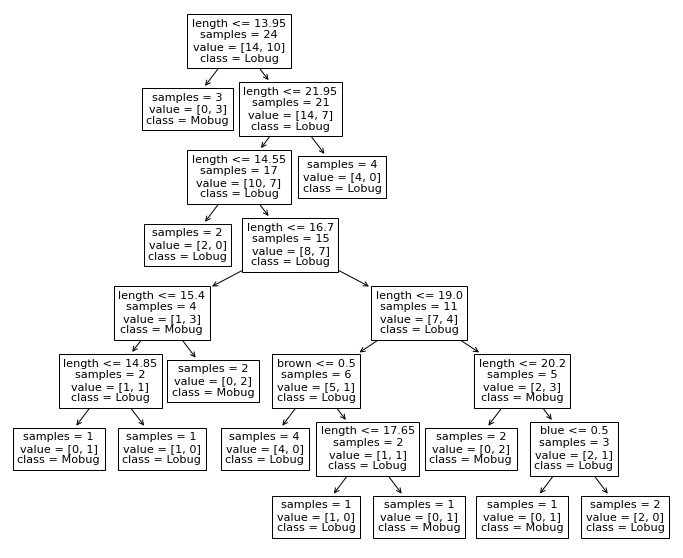

In [11]:
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(12, 10))
_ = plot_tree(model, feature_names=X.columns, class_names=model.classes_, impurity=False, ax=ax)

### Example

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

data = np.asarray(pd.read_csv('data/decision-tree.csv', header=None))
X = data[:,0:2]
y = data[:,2]

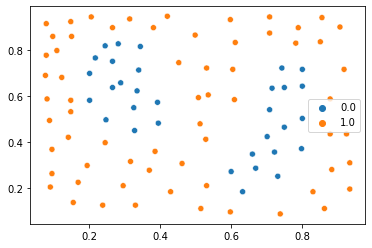

In [13]:
import seaborn as sns
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y);

In [14]:
model = DecisionTreeClassifier()
model.fit(X, y)

y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f'accurace score: {acc}')

accurace score: 1.0


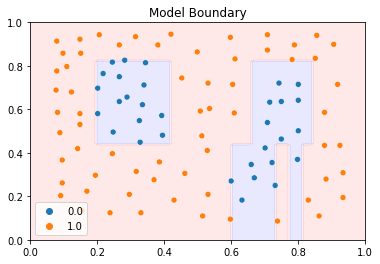

In [15]:
import matplotlib.pyplot as plt

px, py = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
vv = np.vstack([px.ravel(), py.ravel()]).T
pz = model.predict(vv).reshape(px.shape)
plt.contourf(px, py, pz, cmap='bwr', alpha=.1)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y);
plt.title('Model Boundary');

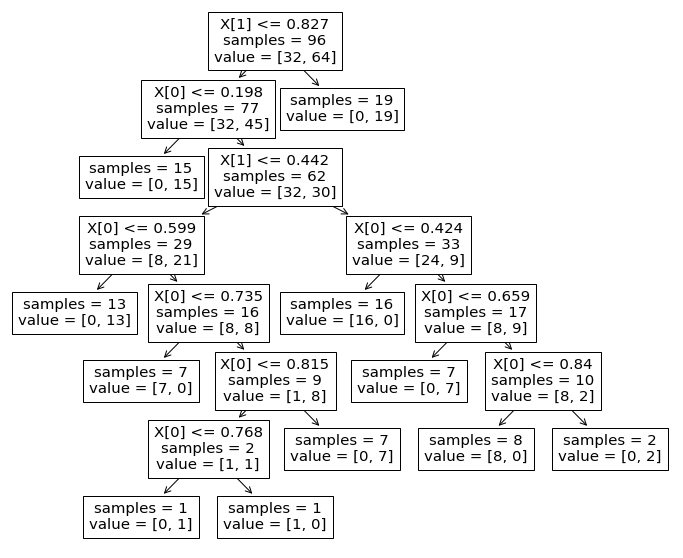

In [16]:
from sklearn.tree import plot_tree
plt.subplots(figsize=(12, 10))
plot_tree(model, impurity=False);

### Optimizing with GridSearchCV

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree_params = [{
    'max_depth': list(range(1, 10)), 
    'min_samples_leaf': list(range(1,3)),
    'min_samples_split': list(range(5,15))
}]
tree = DecisionTreeClassifier()
cvtree = GridSearchCV(tree, tree_params, cv = 10, scoring='accuracy')
cvtree.fit(X, y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'min_samples_leaf': [1, 2],
                          'min_samples_split': [5, 6, 7, 8, 9, 10, 11, 12, 13,
                                                14]}],
             scoring='accuracy')

In [18]:
print(cvtree.best_params_)
print(cvtree.best_score_)

{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 11}
0.7555555555555555


In [19]:
model = DecisionTreeClassifier(max_depth=7, min_samples_leaf=1, min_samples_split=11)
model.fit(X, y)

y_pred = y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f'accurace score: {acc}')

accurace score: 0.96875


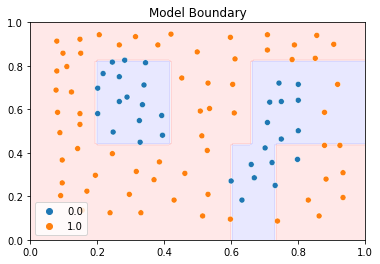

In [20]:
import matplotlib.pyplot as plt

px, py = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
vv = np.vstack([px.ravel(), py.ravel()]).T
pz = model.predict(vv).reshape(px.shape)
plt.contourf(px, py, pz, cmap='bwr', alpha=.1)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y);
plt.title('Model Boundary');